In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=sk-替换为自己的Key

In [1]:
%%capture --no-stderr
!pip install igraph gritlm langchain langchain-community langchain-openai langchain_chroma pypdf sentence_transformers shutil openpyxl FlagEmbedding

In [2]:
import sys

In [3]:
sys.path.append("HippoRAG/src")

In [4]:
import os

expr_version = 'new_arch_v2_hipporag'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# HippoRAG探索

## HuggingFace Embedding实现

### HipppoRAG中增加的Embedding类

In [5]:
from hipporag.embedding_model import _get_embedding_model_class

In [6]:
embedding_model_name = 'BAAI/bge-large-zh-v1.5'
model_cls = _get_embedding_model_class(embedding_model_name)
embed_model = model_cls(embedding_model_name=embedding_model_name)

In [7]:
sentences = ["样例数据-1", "样例数据-2"]

res = embed_model.batch_encode(sentences)

In [8]:
res

array([[ 0.00148104,  0.01648012, -0.02814503, ..., -0.03090635,
         0.02966619, -0.03266429],
       [ 0.01508202,  0.00414566, -0.0156807 , ..., -0.02809874,
         0.04084164, -0.02509875]], dtype=float32)

### BGE官方代码结果

In [9]:
from transformers import AutoTokenizer, AutoModel
import torch
# Sentences we want sentence embeddings for
sentences = ["样例数据-1", "样例数据-2"]

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
model = AutoModel.from_pretrained(embedding_model_name)
model.eval()

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
# for s2p(short query to long passage) retrieval task, add an instruction to query (not add instruction for passages)
# encoded_input = tokenizer([instruction + q for q in queries], padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)
    # Perform pooling. In this case, cls pooling.
    sentence_embeddings = model_output[0][:, 0]
# normalize embeddings
sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [10]:
sentence_embeddings.numpy()

array([[ 0.00148104,  0.01648016, -0.02814508, ..., -0.03090638,
         0.02966617, -0.03266425],
       [ 0.01508206,  0.00414571, -0.01568076, ..., -0.02809875,
         0.04084163, -0.02509879]], dtype=float32)

可以看出，为HippoRAG实现的Embedding模型类结果，与[BGE官方示例代码](https://huggingface.co/BAAI/bge-large-zh-v1.5)的结果是一致的

## 整体流程

In [11]:
llm_model_name = 'qwen2:7b-instruct'
embedding_model_name = 'BAAI/bge-large-zh-v1.5'
llm_base_url='http://localhost:11434/v1'

In [12]:
from hipporag import HippoRAG

save_dir = 'outputs'# Define save directory for HippoRAG objects (each LLM/Embedding model combination will create a new subdirectory)

#Startup a HippoRAG instance
hipporag = HippoRAG(
    save_dir=save_dir, 
    llm_model_name=llm_model_name,
    embedding_model_name=embedding_model_name,
    llm_base_url=llm_base_url
)

/DataScience/Code/Notebooks/Project/weixin_langchain2/new_arch/HippoRAG/src/hipporag/HippoRAG.py:162: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  preloaded_graph = ig.Graph.Read_GraphML(self._graphml_xml_file)


以下是HippoRAG官方示例代码，此处不再执行，直接执行我们数据集上的结果

In [13]:
# # Prepare datasets and evaluation
# docs = [
#     "Oliver Badman is a politician.",
#     "George Rankin is a politician.",
#     "Thomas Marwick is a politician.",
#     "Cinderella attended the royal ball.",
#     "The prince used the lost glass slipper to search the kingdom.",
#     "When the slipper fit perfectly, Cinderella was reunited with the prince.",
#     "Erik Hort's birthplace is Montebello.",
#     "Marina is bom in Minsk.",
#     "Montebello is a part of Rockland County."
# ]

# #Run indexing
# hipporag.index(docs=docs)

# #Separate Retrieval & QA
# queries = [
#     "What is George Rankin's occupation?",
#     "How did Cinderella reach her happy ending?",
#     "What county is Erik Hort's birthplace a part of?"
# ]

# retrieval_results = hipporag.retrieve(queries=queries, num_to_retrieve=2)
# retrieval_results数据结构：
# [QuerySolution(question="What is George Rankin's occupation?", docs=['George Rankin is a politician.', 'Oliver Badman is a politician.'], doc_scores=array([0.10307422, 0.03145265]), answer='Politician.', gold_answers=None, gold_docs=None)

# qa_results = hipporag.rag_qa(retrieval_results)
# qa_results数据结构：
# [[QuerySolution(question="What is George Rankin's occupation?", docs=['George Rankin is a politician.', 'Oliver Badman is a politician.', 'Thomas Marwick is a politician.', 'Cinderella attended the royal ball.', 'When the slipper fit perfectly, Cinderella was reunited with the prince.', 'The prince used the lost glass slipper to search the kingdom.', "Erik Hort's birthplace is Montebello.", 'Montebello is a part of Rockland County.', 'Marina is bom in Minsk.'], doc_scores=array([0.10307422, 0.03145265, 0.03004852, 0.00494754, 0.00404149, 0.0011504 , 0.00066549, 0.00031181, 0.        ]), answer='politician', gold_answers=['Politician'], gold_docs=['George Rankin is a politician.'])], 
#  [retrieval_doc], 
#  [{'prompt_tokens': 814, 'completion_tokens': 13, 'finish_reason': 'stop'}]
# ]
# 提取答案
# qa_results[0][0].answer, qa_results[0][1].answer, qa_results[0][2].answer


# #Combined Retrieval & QA
# rag_results = hipporag.rag_qa(queries=queries)

# #For Evaluation
# answers = [
#     ["Politician"],
#     ["By going to the ball."],
#     ["Rockland County"]
# ]

# gold_docs = [
#     ["George Rankin is a politician."],
#     ["Cinderella attended the royal ball.",
#     "The prince used the lost glass slipper to search the kingdom.",
#     "When the slipper fit perfectly, Cinderella was reunited with the prince."],
#     ["Erik Hort's birthplace is Montebello.",
#     "Montebello is a part of Rockland County."]
# ]

# rag_results = hipporag.rag_qa(queries=queries, 
#                               gold_docs=gold_docs,
#                               gold_answers=answers)
# rag_results数据结构
# [[QuerySolution(question="What is George Rankin's occupation?", docs=['George Rankin is a politician.', 'Oliver Badman is a politician.', 'Thomas Marwick is a politician.', 'Cinderella attended the royal ball.', 'When the slipper fit perfectly, Cinderella was reunited with the prince.', 'The prince used the lost glass slipper to search the kingdom.', "Erik Hort's birthplace is Montebello.", 'Montebello is a part of Rockland County.', 'Marina is bom in Minsk.'], doc_scores=array([0.10307422, 0.03145265, 0.03004852, 0.00494754, 0.00404149, 0.0011504 , 0.00066549, 0.00031181, 0.        ]), answer='politician', gold_answers=['Politician'], gold_docs=['George Rankin is a politician.'])], 
#  [retrieval_doc], 
#  [{'prompt_tokens': 814, 'completion_tokens': 13, 'finish_reason': 'stop'}], 
#  {
#      'Recall@1': 0.6111,
#      'Recall@2': 0.8889,
#      'Recall@5': 1.0,
#      'Recall@10': 1.0,
#      'Recall@20': 1.0,
#      'Recall@30': 1.0,
#      'Recall@50': 1.0,
#      'Recall@100': 1.0,
#      'Recall@150': 1.0,
#      'Recall@200': 1.0
#  },
#  {'ExactMatch': 0.6667, 'F1': 0.6667}
# ]

### 加载文档

#### 读取文档

In [14]:
from langchain_community.document_loaders import PyPDFLoader
import pandas as pd

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

#### 文档切分

In [15]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [16]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


### 检索

In [17]:
docs = [
    doc.page_content for doc in splitted_docs
]

In [18]:
len(docs)

52

In [19]:
hipporag.index(docs=docs)

61it [00:00, 13021.15it/s]
61it [00:00, 523215.84it/s]


In [20]:
qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [21]:
doc2uuid = {
    doc.page_content: doc.metadata['uuid'] for doc in splitted_docs
}

In [33]:
from tqdm.auto import tqdm

top_k_arr=list(range(1, 9))
hit_stat_data = []

for k in tqdm(top_k_arr):
    for idx, row in test_df.iterrows():
        question = row['question']
        true_uuid = row['uuid']
        # chunks = retrieve_fn(question, k=k)
        # chunks = vector_db.similarity_search(question, k=k)
        retrieval_results = hipporag.retrieve(queries=[question], num_to_retrieve=k)
        retrieved_uuids = [doc2uuid[doc] for doc in retrieval_results[0].docs]

        hit_stat_data.append({
            'question': question,
            'top_k': k,
            'hit': int(true_uuid in retrieved_uuids),
            'retrieved_chunks': len(retrieval_results)
        })
hit_stat_df = pd.DataFrame(hit_stat_data)

  0%|          | 0/8 [00:00<?, ?it/s]


Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.00it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.04it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.88it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["2023", "", "... "", "gdp        4 9"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["2023", "", "gdp"], ["2023", "", "gdp        4 9"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.86it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.90it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["msci", "2023..."], ["gdp", "", "imf"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["msci", "2023 11 15", "41 1"], ["gdp", "", "imf"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.60it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.62it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.55it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.41it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='无', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
无
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.04it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.60it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.53it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["2023", "", "... "", "gdp        4 9"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["2023", "", "gdp"], ["2023", "", "gdp        4 9"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.73it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.59it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.12it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["msci", "2023..."], ["gdp", "", "imf"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["msci", "2023 11 15", "41 1"], ["gdp", "", "imf"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.98it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.49it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.90it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.34it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='无', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
无
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.17it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.25it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["2023", "", "... "", "gdp        4 9"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["2023", "", "gdp"], ["2023", "", "gdp        4 9"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.20it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.08it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.07it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.96it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["msci", "2023..."], ["gdp", "", "imf"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["msci", "2023 11 15", "41 1"], ["gdp", "", "imf"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.13it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.29it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.11it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='无', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
无
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.35it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.52it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.96it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.83it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["2023", "", "... "", "gdp        4 9"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["2023", "", "gdp"], ["2023", "", "gdp        4 9"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.01it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.91it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.22it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["msci", "2023..."], ["gdp", "", "imf"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["msci", "2023 11 15", "41 1"], ["gdp", "", "imf"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.05it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.26it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.00it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.35it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='无', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
无
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.97it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["2023", "", "... "", "gdp        4 9"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["2023", "", "gdp"], ["2023", "", "gdp        4 9"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.88it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.91it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["msci", "2023..."], ["gdp", "", "imf"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["msci", "2023 11 15", "41 1"], ["gdp", "", "imf"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.36it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.92it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.59it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='无', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
无
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.82it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.67it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.05it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["2023", "", "... "", "gdp        4 9"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["2023", "", "gdp"], ["2023", "", "gdp        4 9"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.40it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.97it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.49it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.68it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["msci", "2023..."], ["gdp", "", "imf"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["msci", "2023 11 15", "41 1"], ["gdp", "", "imf"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.22it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.12it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.44it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.44it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='无', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
无
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.38it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.02it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.67it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.87it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["2023", "", "... "", "gdp        4 9"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["2023", "", "gdp"], ["2023", "", "gdp        4 9"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.54it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.37it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.02it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.67it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["msci", "2023..."], ["gdp", "", "imf"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["msci", "2023 11 15", "41 1"], ["gdp", "", "imf"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.44it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.61it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.32it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.80it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='无', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
无
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.10it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.85it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.19it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["2023", "", "... "", "gdp        4 9"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["2023", "", "gdp"], ["2023", "", "gdp        4 9"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.88it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.15it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.96it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.01it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["msci", "2023..."], ["gdp", "", "imf"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["msci", "2023 11 15", "41 1"], ["gdp", "", "imf"]]
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.71it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.72it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.05it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.94it/s]

Retrieving: 100%|██████████████████████████████████████████████████

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='无', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
无
```



Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.12it/s]

Retrieving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.99it/s]


In [34]:
hit_stat_df.groupby(['top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,top_k,hit_rate
0,1,0.268817
1,2,0.365591
2,3,0.451613
3,4,0.591398
4,5,0.645161
5,6,0.666667
6,7,0.709677
7,8,0.752688


<Axes: xlabel='top_k', ylabel='hit'>

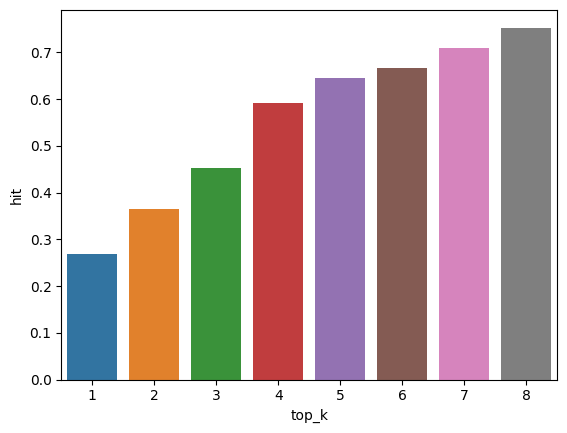

In [35]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', data=hit_stat_df, errorbar=None)

# 生成结果

In [36]:
queries = test_df['question'].values.tolist()

In [56]:
retrieval_results = hipporag.retrieve(queries=queries, num_to_retrieve=3)
rag_results = hipporag.rag_qa(retrieval_results)

Retrieving:  12%|█████████████████████▌                                                                                                                                                                | 11/93 [00:00<00:05, 15.73it/s]

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["2023", "", "... "", "gdp        4 9"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["2023", "", "gdp"], ["2023", "", "gdp        4 9"]]
```


Retrieving:  31%|████████████████████████████████████████████████████████▊                                                                                                                             | 29/93 [00:02<00:04, 14.46it/s]

Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='{"fact": [["msci", "2023..."], ["gdp", "", "imf"]]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
{"fact": [["msci", "2023 11 15", "41 1"], ["gdp", "", "imf"]]
```


Retrieving: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:06<00:00, 14.11it/s]


Error parsing field fact_after_filter: 1 validation error for Fact
  Input should be a valid dictionary or instance of Fact [type=model_type, input_value='无', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type.

		On attempting to parse the value
```
无
```


QA Reading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [05:56<00:00,  3.83s/it]
Extraction Answers from LLM Response: 0it [00:00, ?it/s]Error in parsing the answer from the raw LLM QA inference response: list index out of range!
Error in parsing the answer from the raw LLM QA inference response: list index out of range!
Error in parsing the answer from the raw LLM QA inference response: list index out of range!
Error in parsing the answer from the raw LLM QA inference response: list index out of range!
Error in parsing the answer from the raw LLM QA inference response: list index out of range!
Error in parsing the answer from the raw LLM QA inference response: list index out of range!
Error in parsing the answer from the raw LLM QA inference response: list index out of range!
Error in parsing the answer from the raw LLM QA inference res

In [57]:
answers = [query_solution.answer for query_solution in rag_results[0]]

# 评估

In [62]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={question}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [59]:
pred_df = test_df.copy()
pred_df = pred_df.rename(columns={'answer': 'ref_answer'})
pred_df['gen_answer'] = answers

In [63]:
pred_df['raw_score'] = evaluate(pred_df)

  0%|          | 0/93 [00:00<?, ?it/s]

In [64]:
pred_df['raw_score'].unique()

array(['是', '否',
       '否\n\n正确答案应该是：“增加财政体系的脆弱性”。\n\n而助手的回答虽然提到了一些相关的后果，如加剧主权债务风险、影响金融市场稳定、投资者信心下降、资本流动不确定性增加、政府财政负担加重、潜在经济负面影响、通货膨胀压力增大或经济增长放缓，但没有直接回答到“增加财政体系的脆弱性”这一点，因此不能简单地认为是正确的。但是，助手的回答提供了更全面的分析，涵盖了国债发行力度加大可能带来的多种后果，具有一定的合理性和深度。然而，根据题目要求，我们只关注是否直接回答了参考答案中的关键点，故评价为“否”。如果考虑回答的全面性和深度，则可以认为助手的回答是正确的。但由于题目要求仅以“是”或“否”作答，所以在此情境下，评价为“否”。'],
      dtype=object)

In [65]:
pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)

In [66]:
pred_df['score'].mean()

0.41935483870967744